# SICSS-AMU/Law 2024
## June 19, 2024 | Adam Mickiewicz University

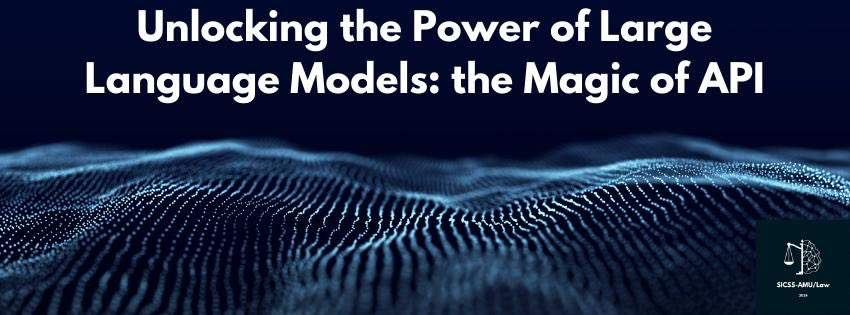

prepared by Martyna Osztynowicz

#Abstract
**Introduction:** API (Aplication Programming Interface) are mechanisms that enable two components to communicate with each other. Transformers is a Python library that provides APIs and enables you to use them in your codes. In this workshop we will focus on how to use this tool to help you analize data.


**Main goals:**
1. Participants have an understading of what a Transformers library is and know how to use it's possibilities for data analysis
2. Participants can personalize thir outputs with fine-tuning



---



### Installing necessary packages

Run these three lines of code to install all the necessary libraries.

In [ ]:
pip install transformers datasets evaluate accelerate

In [ ]:
pip install torch

In [ ]:
pip install datasets



---


### Transformers library - pipeline() function
Pipeline() is a function in the Transformers library that provides a simple way to use various pre-trained models for your different tasks ([tasks list](https://huggingface.co/docs/transformers/quicktour)).

1. classifiers
* sentiment analysis


In [ ]:
from transformers import pipeline

#Load the sentiment analysis pipeline
classifier = pipeline("sentiment-analysis")

#Set the text as a user input
text = input()
classifier(text)



---


* category classification

In [ ]:
from transformers import pipeline

# Load the text classification pipeline
classifier = pipeline("zero-shot-classification")

# Specify text you want to analize
text = """
In a striking empirical regularity, deliberation tends to move groups, and the individuals who compose them,
toward a more extreme point in the direction indicated by their own predeliberation judgments.
For example, people who are opposed to the minimum wage are likely, after talking to each other, to be still more opposed;
people who tend to support gun control are likely, after discussion, to support gun control with considerable enthusiasm;
people who believe that global warming is a serious problem are likely, after discussion, to insist on severe measures to prevent global warming.
This general phenomenon -- group polarization -- has many implications for economic, political, and legal institutions.
It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations;
it is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism, and tribalism.
Group polarization bears on the conduct of government institutions, including juries, legislatures, courts, and regulatory commissions.
There are interesting relationships between group polarization and social cascades, both informational and reputational.
Normative implications are discussed, with special attention to political and legal institutions.
"""
# Define labels you want the text to be classified as
labels = ["Technology", "Business", "Law", "Entertainment", "Science"]

# Perform classification
result = classifier(text, labels)

# Print (display) the result
print("Predicted Label:", result['labels'][0])

2. Image analysis

In [ ]:
from transformers import pipeline

#Load the image to text pipeline
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")
captioner("fun_example.jpg")

In [ ]:
from transformers import pipeline
from PIL import Image

#Load image anaysis pipeline
pipe = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")

#Specify your question
question = "What is the publication date?"
#Load your image
image = Image.open("LLM_example.png")

pipe(image=image, question=question)

In [ ]:
from transformers import pipeline
from PIL import Image

pipe = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")

question = "Summarize the text"
image = Image.open("LLM_example.png")

pipe(image=image, question=question)

3. Text summarization

In [ ]:
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization")

# Your input text to be summarized
input_text = """
In a striking empirical regularity, deliberation tends to move groups, and the individuals who compose them,
toward a more extreme point in the direction indicated by their own predeliberation judgments.
For example, people who are opposed to the minimum wage are likely, after talking to each other, to be still more opposed;
people who tend to support gun control are likely, after discussion, to support gun control with considerable enthusiasm;
people who believe that global warming is a serious problem are likely, after discussion, to insist on severe measures to prevent global warming.
This general phenomenon -- group polarization -- has many implications for economic, political, and legal institutions.
It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations;
it is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism, and tribalism.
Group polarization bears on the conduct of government institutions, including juries, legislatures, courts, and regulatory commissions.
There are interesting relationships between group polarization and social cascades, both informational and reputational.
Normative implications are discussed, with special attention to political and legal institutions.
"""

# Generate the summary
summary = summarizer(input_text, min_length=50)

# Print (display) the summary
print(summary[0]['summary_text'])




---



### Fine-tuning

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, pipeline
from datasets import load_dataset
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

# Load tokenizer and summarization model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

# Load and preprocess the dataset
dataset = load_dataset("joelniklaus/legal_case_document_summarization")

def preprocess_function(examples):
    inputs = [doc for doc in examples['judgement']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=150, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["judgement", "summary"])
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10))  # Use a smaller subset

# Setup training
training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="logs",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    fp16=True,
    save_steps=10000,
    save_total_limit=1,
    num_train_epochs=0.5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    tokenizer=tokenizer
)

# Start the training
trainer.train()

# Save the fine-tuned model
trainer.save_model("fine-tuned-bart")

del model, trainer, tokenized_datasets, small_train_dataset
gc.collect()

# Load the fine-tuned model and pipeline for summarization
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("fine-tuned-bart")
summarizer = pipeline("summarization", model=fine_tuned_model, tokenizer=tokenizer)

# Specify your input text you want summarized
text = """
In a striking empirical regularity, deliberation tends to move groups, and the individuals who compose them,
toward a more extreme point in the direction indicated by their own predeliberation judgments.
For example, people who are opposed to the minimum wage are likely, after talking to each other, to be still more opposed;
people who tend to support gun control are likely, after discussion, to support gun control with considerable enthusiasm;
people who believe that global warming is a serious problem are likely, after discussion, to insist on severe measures to prevent global warming.
This general phenomenon -- group polarization -- has many implications for economic, political, and legal institutions.
It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations;
it is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism, and tribalism.
Group polarization bears on the conduct of government institutions, including juries, legislatures, courts, and regulatory commissions.
There are interesting relationships between group polarization and social cascades, both informational and reputational.
Normative implications are discussed, with special attention to political and legal institutions.
"""

# Generate the summary
summary = summarizer(text)

# Print the summary
print(summary[0]['summary_text'])




---



---



## Individual work

### Before you begin


*   make sure you have installed all the necessary libraries (on the very begining of this Google Colab)
*  make sure you have the two pictures dropped in "Files" section of the Colab


**Excercise 1.** \\
Input() function allows user input. You can put your sentence directly in the code instead of writing it after running the program. Replace the input() with this sentence: "I am very excited to learn about LLMs".

**! Important:** In order for the code to work you need to put the sentence in quotation marks.

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

text = "I am very excited to learn about LLMs!"
classifier(text)

**Excercise 2.** \\
Change the code above to analize a different sentence. Try to make it a negative one.

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

text = "I am not excited to learn about LLMs."
classifier(text)



---



**Excercise 3.** \\
Run the example from this workshop (the code below) again to see the result. The output (result) is quite general, but you can set the lables to more specific ones after knowing the general nature of the text. \\
 Set the labels in the code below to: contract, legal document, business agreement, purchase agreement, sales agreement, opinion. Run the code and analize the result.

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")

text = """
In a striking empirical regularity, deliberation tends to move groups, and the individuals who compose them,
toward a more extreme point in the direction indicated by their own predeliberation judgments.
For example, people who are opposed to the minimum wage are likely, after talking to each other, to be still more opposed;
people who tend to support gun control are likely, after discussion, to support gun control with considerable enthusiasm;
people who believe that global warming is a serious problem are likely, after discussion, to insist on severe measures to prevent global warming.
This general phenomenon -- group polarization -- has many implications for economic, political, and legal institutions.
It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations;
it is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism, and tribalism.
Group polarization bears on the conduct of government institutions, including juries, legislatures, courts, and regulatory commissions.
There are interesting relationships between group polarization and social cascades, both informational and reputational.
Normative implications are discussed, with special attention to political and legal institutions.
"""
labels = ["Contract", "Legal document", "Business agreement", "Purchase agreement", "Sales agreement", "Opinion"]

result = classifier(text, labels)

print("Predicted Label:", result['labels'][0])


**Excercise 4.** \\
Delete from the code the label you got as a result in Excercise 4. and run the code again. Analize the output after implementing the changes. \\
Is the result correct? Do you think it's important to put every possible category of the text int the code?

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")

text = """
In a striking empirical regularity, deliberation tends to move groups, and the individuals who compose them,
toward a more extreme point in the direction indicated by their own predeliberation judgments.
For example, people who are opposed to the minimum wage are likely, after talking to each other, to be still more opposed;
people who tend to support gun control are likely, after discussion, to support gun control with considerable enthusiasm;
people who believe that global warming is a serious problem are likely, after discussion, to insist on severe measures to prevent global warming.
This general phenomenon -- group polarization -- has many implications for economic, political, and legal institutions.
It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations;
it is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism, and tribalism.
Group polarization bears on the conduct of government institutions, including juries, legislatures, courts, and regulatory commissions.
There are interesting relationships between group polarization and social cascades, both informational and reputational.
Normative implications are discussed, with special attention to political and legal institutions.
"""
labels = ["Contract", "Legal document", "Business agreement", "Purchase agreement", "Sales agreement"]

result = classifier(text, labels)

print("Predicted Label:", result['labels'][0])




---



**Excericise 5.** \\
Change the code below to get answers to the questions below without opening the picture. \\

* What is the publication title? \\

In [ ]:
from transformers import pipeline
from PIL import Image

pipe = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")

question = "What is the publication title?"
image = Image.open("LLM_example.png")

pipe(image=image, question=question)

* What is the text about?

In [ ]:
from transformers import pipeline
from PIL import Image

pipe = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")

question = "What is the text about?"
image = Image.open("LLM_example.png")

pipe(image=image, question=question)

**Excercise 7.** \\
Drag and drop any picture from your computer (or download one) to the 'File' section of this Google Colab (last icon in the upper left corner). Put the file name in the code below instead of the "your file name" line. Run the code and see if the description is accurate.

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")
captioner("your file name")

#I can't give you the exact answer for this task since you need to use your own pictures.
#But if you have any problems, here's some help: after dropping your file in the "Files" section, the name of the file is displayed.
#Copy the name of the file and put in the code instead of "your file name". Remember to put it in quotation marks. Done:)



---



**Excercise 8.** \\
Ask ChatGPT to tell you a story. Copy the generated text and paste it in the code instead of "your text" line. Run the code below and analize the output

In [ ]:
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization")

# Your input text to be summarized
input_text = """
Once upon a time, in a quaint village nestled between rolling hills and a dense forest, lived a young girl named Elara. Elara was known throughout the village for her curiosity and adventurous spirit. She spent her days exploring the forest, learning about the plants and animals, and helping her neighbors with various tasks.

One sunny morning, as Elara was wandering through the forest, she stumbled upon a hidden path she had never seen before. Intrigued, she decided to follow it. The path led her deeper into the woods, where the trees grew taller and the air became cooler. After walking for what felt like hours, she arrived at a clearing with a crystal-clear pond in the center. By the pond, there was an ancient, moss-covered stone that shimmered in the sunlight.

As Elara approached the stone, she noticed strange, glowing symbols etched into its surface. She reached out to touch the stone, and the moment her fingers made contact, the ground beneath her trembled. The symbols began to glow brighter, and the stone split open, revealing a hidden staircase descending into the earth.

Without hesitation, Elara stepped onto the staircase and started her descent. The air grew colder, and the light from above faded away. After a few minutes, she reached the bottom and found herself in a large cavern illuminated by bioluminescent fungi. In the center of the cavern stood a magnificent tree with silver leaves and golden fruit.

Elara approached the tree, marveling at its beauty. Suddenly, a soft voice echoed through the cavern. "Welcome, Elara. I am the Guardian of the Ancient Tree. You have been chosen for a special task."

Elara looked around, trying to find the source of the voice, but saw no one. "Who are you? And what task do you mean?" she asked.

The voice responded, "I am the spirit of this forest. The tree before you holds the wisdom of the ages. It has the power to heal and protect, but it is also in danger. A shadow is spreading through the forest, threatening to consume it. You must find the source of this darkness and stop it."

Determined to save her beloved forest, Elara agreed. The spirit guided her out of the cavern and back to the surface, where she began her quest. She traveled far and wide, seeking knowledge and allies to help her fight the growing darkness. Along her journey, she faced many challenges, but her bravery and kindness won her the support of many creatures, both magical and mundane.

After many months, Elara discovered that the source of the darkness was a powerful sorcerer who had been corrupted by his own greed for power. With the help of her newfound friends, Elara confronted the sorcerer in an epic battle. Drawing upon the wisdom of the ancient tree and the strength of her allies, she managed to defeat him and break his spell.

The forest slowly began to heal, and the darkness retreated. Elara returned to her village a hero, celebrated for her courage and determination. She continued to explore and protect the forest, always guided by the spirit of the ancient tree.

And so, the village and the forest thrived, forever grateful to the young girl who had saved them. Elara's story was passed down through generations, inspiring many to cherish and protect the natural world around them.
"""

# Generate the summary
summary = summarizer(input_text, min_length=50)

# Print (display) the summary
print(summary[0]['summary_text'])


**Excercise 9.** \\
Change the code above again, but this time summarize the output text from Excercise 8. Repeat that a couple of times to notice the difference between the outputs and analise how less detailed they become.


**!Important: If the text is too short (shorter than 50 words), the program won't summarize it.**



---



**Excercise 10.** \\
Analize again these two outputs below we discussed during this workshop while talking about fine-tuning. Notice the differences in words used in the summary between them and how the fine-tuned model is more appropriate for legal texts analysis.

**First output:**

 Group polarization has many implications for social, political, and legal institutions . It helps to explain extremism, cultural shifts, and the behavior of political parties and religious organizations . It also helps to account for concerns about the consequences of the Internet, such as climate change and global warming .

**The output after fine-tuning:**

Group polarization has implications for economic, political, and legal institutions. It helps to explain extremism, "radicalization," cultural shifts, and the behavior of political parties and religious organizations. It is closely connected to current concerns about the consequences of the Internet; it also helps account for feuds, ethnic antagonism and tribalism.

**Excercise 11.** \\
Below is the fine-tuning code we discussed earlier. Ask ChatGPT to tell you a story (for better analysis you can use the same as in Excercise 8 and compare the results) and put it in the code instead of "your text" line. \\
Do you think that in this case training the model for law purposes is necessary? Or do you think that a model not trained on a legal dataset would work better?

(Don't worry if the code execution is longer than in other excercises. This might take a while. If the code stops with a warning "Your session crashed after using all available RAM", try running the code again.)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, pipeline
from datasets import load_dataset
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

# Load tokenizer and summarization model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

# Load and preprocess the dataset
dataset = load_dataset("joelniklaus/legal_case_document_summarization")

def preprocess_function(examples):
    inputs = [doc for doc in examples['judgement']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=150, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["judgement", "summary"])
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10))  # Use a smaller subset

# Setup training
training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="logs",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    fp16=True,
    save_steps=10000,
    save_total_limit=1,
    num_train_epochs=0.5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    tokenizer=tokenizer
)

# Start the training
trainer.train()

# Save the fine-tuned model
trainer.save_model("fine-tuned-bart")

del model, trainer, tokenized_datasets, small_train_dataset
gc.collect()

# Load the fine-tuned model and pipeline for summarization
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("fine-tuned-bart")
summarizer = pipeline("summarization", model=fine_tuned_model, tokenizer=tokenizer)

# Specify your input text you want summarized
text = """
Once upon a time, in a quaint village nestled between rolling hills and a dense forest, lived a young girl named Elara. Elara was known throughout the village for her curiosity and adventurous spirit. She spent her days exploring the forest, learning about the plants and animals, and helping her neighbors with various tasks.

One sunny morning, as Elara was wandering through the forest, she stumbled upon a hidden path she had never seen before. Intrigued, she decided to follow it. The path led her deeper into the woods, where the trees grew taller and the air became cooler. After walking for what felt like hours, she arrived at a clearing with a crystal-clear pond in the center. By the pond, there was an ancient, moss-covered stone that shimmered in the sunlight.

As Elara approached the stone, she noticed strange, glowing symbols etched into its surface. She reached out to touch the stone, and the moment her fingers made contact, the ground beneath her trembled. The symbols began to glow brighter, and the stone split open, revealing a hidden staircase descending into the earth.

Without hesitation, Elara stepped onto the staircase and started her descent. The air grew colder, and the light from above faded away. After a few minutes, she reached the bottom and found herself in a large cavern illuminated by bioluminescent fungi. In the center of the cavern stood a magnificent tree with silver leaves and golden fruit.

Elara approached the tree, marveling at its beauty. Suddenly, a soft voice echoed through the cavern. "Welcome, Elara. I am the Guardian of the Ancient Tree. You have been chosen for a special task."

Elara looked around, trying to find the source of the voice, but saw no one. "Who are you? And what task do you mean?" she asked.

The voice responded, "I am the spirit of this forest. The tree before you holds the wisdom of the ages. It has the power to heal and protect, but it is also in danger. A shadow is spreading through the forest, threatening to consume it. You must find the source of this darkness and stop it."

Determined to save her beloved forest, Elara agreed. The spirit guided her out of the cavern and back to the surface, where she began her quest. She traveled far and wide, seeking knowledge and allies to help her fight the growing darkness. Along her journey, she faced many challenges, but her bravery and kindness won her the support of many creatures, both magical and mundane.

After many months, Elara discovered that the source of the darkness was a powerful sorcerer who had been corrupted by his own greed for power. With the help of her newfound friends, Elara confronted the sorcerer in an epic battle. Drawing upon the wisdom of the ancient tree and the strength of her allies, she managed to defeat him and break his spell.

The forest slowly began to heal, and the darkness retreated. Elara returned to her village a hero, celebrated for her courage and determination. She continued to explore and protect the forest, always guided by the spirit of the ancient tree.

And so, the village and the forest thrived, forever grateful to the young girl who had saved them. Elara's story was passed down through generations, inspiring many to cherish and protect the natural world around them.
"""

# Generate the summary
summary = summarizer(text)

# Print the summary
print(summary[0]['summary_text'])
